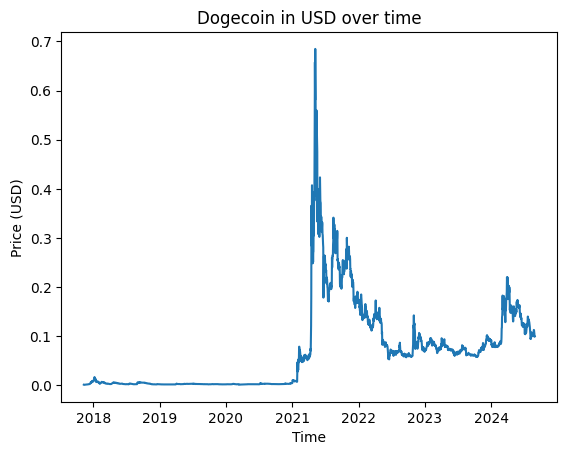

(2485, 4) (2485,)
Training Shape: (2236, 100, 4) (2236, 25)
Testing Shape: (126, 100, 4) (126, 25)
Training Shape: torch.Size([2236, 100, 4]) torch.Size([2236, 25])
Testing Shape: torch.Size([126, 100, 4]) torch.Size([126, 25])
Epoch: 0, train loss: 0.05731, test loss: 0.06526
Epoch: 10, train loss: 0.02597, test loss: 0.02882
Epoch: 20, train loss: 0.01497, test loss: 0.01140
Epoch: 30, train loss: 0.00919, test loss: 0.00470
Epoch: 40, train loss: 0.00530, test loss: 0.00254
Epoch: 50, train loss: 0.00344, test loss: 0.00230
Epoch: 60, train loss: 0.00278, test loss: 0.00214
Epoch: 70, train loss: 0.00245, test loss: 0.00158
Epoch: 80, train loss: 0.00225, test loss: 0.00124
Epoch: 90, train loss: 0.00213, test loss: 0.00113
Epoch: 100, train loss: 0.00205, test loss: 0.00104
Epoch: 110, train loss: 0.00198, test loss: 0.00100
Epoch: 120, train loss: 0.00193, test loss: 0.00100
Epoch: 130, train loss: 0.00189, test loss: 0.00098
Epoch: 140, train loss: 0.00185, test loss: 0.00097
Epo

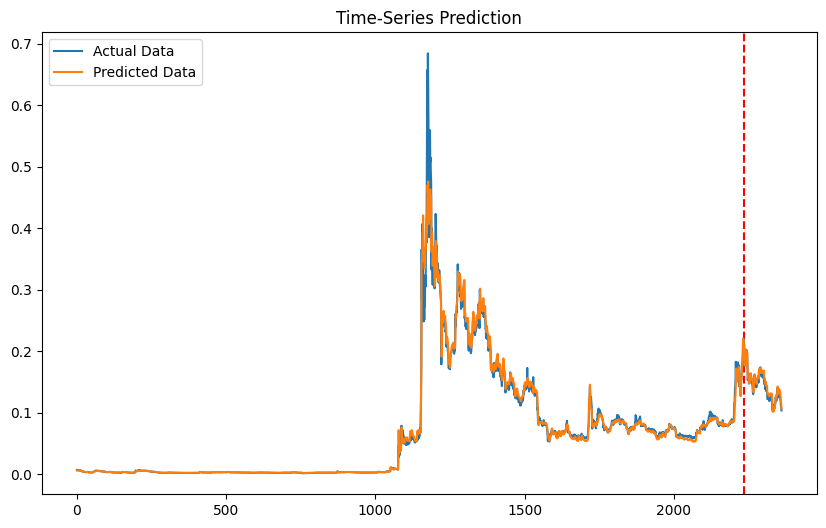

RMSE 0.012576208


In [4]:
"""
1) Importing libraries
"""
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')
"""
2) Preprocessing the data
"""
df = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/DOGE-USD?period1=1510185600&period2=1724853923&interval=1d&events=history&includeAdjustedClose=true', index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

#plot the data
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Dogecoin in USD over time")
plt.savefig("initial_plot.png", dpi=950)
plt.show()

#print shape of data
X, y = df.drop(columns=['Close']), df.Close.values
print(X.shape, y.shape)

mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

"""
3) Split the data into training and testing set
"""
# split a multivariate sequence past, future
# samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 25)
#print(X_ss.shape, y_mm.shape)
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()
#print(y_mm[0])
#print(y_trans[99:149].squeeze(1))

total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:train_test_cutoff]
X_test = X_ss[train_test_cutoff:]

y_train = y_mm[:train_test_cutoff]
y_test = y_mm[train_test_cutoff:]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

# convert to pytorch tensors
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0], 100,
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0], 100,
                                      X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

"""
4) LSTM model
"""
import torch
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes  # Output size
        self.num_layers = num_layers      # Number of recurrent layers in the GRU
        self.input_size = input_size      # Input size
        self.hidden_size = hidden_size     # Neurons in each GRU layer

        # GRU model
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc_1 = nn.Linear(self.num_layers * hidden_size, 128)  # Fully connected layer
        self.fc_2 = nn.Linear(128, num_classes)  # Final output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        # Hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Propagate input through GRU
        output, hn = self.gru(x, h_0)  # (input, hidden state)

        # Reshape the output for the dense layer
        hn = hn.view(-1, self.num_layers * self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)  # First dense layer
        out = self.relu(out)   # ReLU activation
        out = self.fc_2(out)   # Final output
        return out
"""
5) Training
"""
def training_loop(n_epochs, gru, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        gru.train()
        outputs = gru(X_train)  # Forward pass
        optimiser.zero_grad()    # Zero the gradients
        loss = loss_fn(outputs, y_train)  # Calculate the loss
        loss.backward()          # Backpropagation
        optimiser.step()         # Update weights

        # Test loss
        gru.eval()
        test_preds = gru(X_test)
        test_loss = loss_fn(test_preds, y_test)

        if epoch % 10 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch,
                                                                      loss.item(),
                                                                      test_loss.item()))

# Hyperparameters
n_epochs = 250  # Number of epochs
learning_rate = 0.0008  # Learning rate

input_size = 4  # Number of features
hidden_size = 8  # Neurons in hidden state
num_layers = 1  # Number of stacked GRU layers

num_classes = 25  # Number of output classes

# Create GRU model instance
gru = GRU(num_classes,
           input_size,
           hidden_size,
           num_layers)

# Loss function and optimizer
loss_fn = torch.nn.MSELoss()  # Mean-squared error for regression
optimiser = torch.optim.Adam(gru.parameters(), lr=learning_rate)

# Call the training loop function
training_loop(n_epochs=n_epochs,
              gru=gru,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

"""
6) Prediction
"""
# Transform the data using old transformers
df_X_ss = ss.transform(df.drop(columns=['Close']))  # Scaling features
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1))  # Scaling target

# Split the sequences
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 25)

# Convert to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)

# Reshape the dataset for GRU
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

# Forward pass through the GRU model
train_predict = gru(df_X_ss)  # Use the GRU model here
data_predict = train_predict.data.numpy()  # Convert to numpy
dataY_plot = df_y_mm.data.numpy()

# Inverse transform predictions and actual values
data_predict = mm.inverse_transform(data_predict)
dataY_plot = mm.inverse_transform(dataY_plot)

# Prepare true and predicted values for plotting
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])

# Plotting
plt.figure(figsize=(10, 6))
plt.axvline(x=train_test_cutoff, c='r', linestyle='--')  # Size of the training set
plt.plot(true, label='Actual Data')  # Actual plot
plt.plot(preds, label='Predicted Data')  # Predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=1200)
plt.show()

# Calculate and print RMSE
print("RMSE", np.sqrt(np.mean((np.array(true) - np.array(preds))**2)))